# **Image Retrieval Using HASHNET**

Accurate image retrieval is a core technology for shopping by picture taking, and also becomes a hotspot in the academia and industry. Here, we take a digital device image dataset in a real snap-to-shop scenario, provided in Huawei DIGIX Global AI Challenge. In a Content Based Image Retrieval (CBIR) System, the task is to retrieve similar images from a large database given a query image. The usual procedure is to extract some useful features from the query image, and retrieve images which have similar set of features. For this purpose, a suitable similarity measure is chosen, and images with high similarity scores are retrieved. Naturally the choice of these features play a very important role in the success of this system, and high level features are required to reduce the semantic gap.

Deep Hashing methods are most commonly used to implement content based image retrieval. If you do not know about image retrieval Check out this [paper](https://arxiv.org/pdf/2006.05627.pdf).

Out of all the Deep Hashing methods we shall implement the Hashnet for content based image retrieval. Here is the [paper](https://arxiv.org/pdf/1702.00758.pdf).

If you find the notebook insightful, please do upvote it.

## Setup

Lets start by importing necessary packages. Also make sure that you have added Google Cloud Services to your notebook (if not go to the "Add-ons" section and attach it to your notebook) and are using GPU.

Add train data to your notebook using this dataset https://www.kaggle.com/varenyambakshi/digixai-image-retrieval.

Add test data to your notebook using this dataset https://www.kaggle.com/varenyambakshi/digixalgoai.

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader,Dataset
import os
import math
from PIL import Image, ImageOps
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numbers
import pandas as pd
import argparse
import os.path as osp

from sklearn.preprocessing import StandardScaler
import random
import torch.utils.data as util_data
import matplotlib.pyplot as plt

In [2]:
class Config():  
    training_dir = "../input/digixai-image-retrieval/train_data/"
    label_dir = "../input/digixai-image-retrieval/train_data/label.txt"
    gallery_dir = "../input/digixalgoai/test_data_B/gallery/"
    query_dir = "../input/digixalgoai/test_data_B/query/"
    outfile = "/content/drive/My Drive/log.txt"
    feature_file = "./features.pth"
    model = "./model.pth"
    
    feature_batch_size = 64            #batch size used while extracting features
    train_batch_size = 128             #batch size used while training the network with extracted features
    train_number_epochs = 50          #batch size used while extracting features
    #some tranformations to be applied on the images
    transformer = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

## Helper Functions

Here we define two helper functions. `imshow` is for displaying images while `show_plot` is for plotting the loss function.

In [34]:
def imshow(img,text=None,should_save=False):
    plt.figure(figsize=(21,12))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.figure(figsize=(14,8))
    plt.plot(iteration,loss)
    plt.show()

## Loss


Here we define the loss function of Hashnet. We basically pass two batches of images encoded in hashbits where some images are semantically (content-wise) similar while others are different. The more the distance between hashbits of similar images, the more heavily loss function punishes and vice-versa. To know about the maths you can refer the [paper](https://arxiv.org/pdf/1702.00758.pdf).  



In [4]:
def pairwise_loss_updated(outputs1,outputs2,label1,label2):
    dot_product = torch.mm(outputs1, outputs2.t())
    similarity = (label1.view(-1,1) == label2.view(-1,1).t()).float()
    
    mask_positive = similarity.data > 0
    mask_negative = similarity.data <= 0
    exp_loss = torch.log(1+torch.exp(dot_product)) -similarity * dot_product

    #weight
    S1 = torch.sum(mask_positive.float())
    S0 = torch.sum(mask_negative.float())
    S = S0+S1

    exp_loss[similarity.data > 0] = exp_loss[similarity.data > 0] * (S / S1)
    exp_loss[similarity.data <= 0] = exp_loss[similarity.data <= 0] * (S / S0)

    loss = torch.sum(exp_loss) / S
    return loss

## Network

Although there are many models available, we shall be using RESNET50. We will have broadly three types of layers namely 
1. Convolution layers
1. Fully connected layers 
1. Hashing layer

Instead of training the whole network at once we can use transfered learing and train few of the last layers. To further speed up training we can extract the intermediate feaures so that we do not have to pass the images everytime through the whole network. Instead we can just train on the extracted features.

In [5]:
resnet_dict = {"ResNet18":models.resnet18, "ResNet34":models.resnet34, "ResNet50":models.resnet50, "ResNet101":models.resnet101, "ResNet152":models.resnet152} 
class ResNetFc(nn.Module):
    def __init__(self, name, hash_bit):
        super(ResNetFc, self).__init__()
        model_resnet = resnet_dict[name](pretrained=True)
        self.conv1 = model_resnet.conv1
        self.bn1 = model_resnet.bn1
        self.relu = model_resnet.relu
        self.maxpool = model_resnet.maxpool
        self.layer1 = model_resnet.layer1
        self.layer2 = model_resnet.layer2
        self.layer3 = model_resnet.layer3
        self.layer4 = model_resnet.layer4
        self.avgpool = model_resnet.avgpool

        #convolution layers
        self.feature_layers = nn.Sequential(self.conv1, self.bn1, self.relu, self.maxpool, \
                             self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool)


        #feature layers
        self.fc = nn.Sequential(nn.Linear(model_resnet.fc.in_features,512),
                                nn.Dropout(0.2),
                                nn.ReLU()
                                )
        #hash layers
        self.hash_layer = nn.Linear(512, hash_bit)
        #initializing the layers
        self.hash_layer.weight.data.normal_(0, 0.01)
        self.hash_layer.bias.data.fill_(0.0)

        self.iter_num = 0
        self.__in_features = hash_bit
        self.step_size = 200
        self.gamma = 0.005
        self.power = 0.5
        self.init_scale = 1.0
        self.activation = nn.Tanh()
        self.scale = self.init_scale

    #passing the extracted features through the rest of the network for training
    def train_from_features(self,x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        y = self.hash_layer(x)
        if self.iter_num % self.step_size==0:
            self.scale = self.init_scale * (math.pow((1.+self.gamma*self.iter_num), self.power))
        y = self.activation(self.scale*y)
        return y

    #passing only through the convolution layers to extract intermediate features
    def extractor(self,x):
        x = self.feature_layers(x)    
        return x
    
    #passing through the whole network at once
    def forward(self, x):
        if self.training:
            self.iter_num += 1
        x = self.feature_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        y = self.hash_layer(x)
        if self.iter_num % self.step_size==0:
            self.scale = self.init_scale * (math.pow((1.+self.gamma*self.iter_num), self.power))
        y = self.activation(self.scale*y)
        return y

    def output_num(self):
        return self.__in_features

## Dataset

Defining dataset class for the images. It takes the images applies the tranformations and returns them.

In [6]:
class train_dataset(Dataset):

    def __init__(self, encoding_dict):

      self.encodings = encoding_dict['encodings']
      labels = encoding_dict['labels']
      self.labels = labels

    def __len__(self):  
      return len(self.encodings)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      label1 = encoding_dict['labels'][idx]
      
      should_get_same_class = random.randint(0,1) 

      if should_get_same_class:
          while True:
                #keep looping till the same class image is found
                idx2 = idx + random.randint(-10,10)
                while (idx2>=len(encoding_dict['encodings']) or idx2<0):
                    idx2 = idx + random.randint(-10,10)
                label2 = encoding_dict['labels'][idx2] 
                if label1 == label2:
                    break
                    
      else:
          while True:
                #keep looping till a different class image is found        
                idx2 = int(random.randint(0,len(encoding_dict['encodings'])-1))
                label2 = encoding_dict['labels'][idx2] 
                if label1 != label2:
                    break


      img1 = encoding_dict['encodings'][idx]
      img2 = encoding_dict['encodings'][idx2]
      return img1, img2 , label1, label2

## Feature extractor

In [7]:
class Encodings(Dataset):

    def __init__(self, image_dir, path, transform=None):

        data = pd.read_csv(path, header=None)
        imgs = data.iloc[:,0]
        self.img_path = image_dir+imgs
        self.labels = data.iloc[:,1]
        #self.data =  pd.DataFrame(img_list)
        self.image_dir = image_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.img_path.iloc[idx]
        image = Image.open(img_name)
        image = image.convert("RGB")
        

        if self.transform:
            image = self.transform(image)

        sample = {'image':image, 'name':self.img_path.iloc[idx], 'labels':self.labels.iloc[idx]}

        return sample

In [8]:
def feature_extracter(encoding_dataloader, net, verbosity):
  net.eval()
  with torch.no_grad(): 
    for i_batch, sample in enumerate(encoding_dataloader):
      if torch.cuda.is_available():
        sample['image'] = sample['image'].cuda()
      encoding = net.extractor(sample['image'])
      if not i_batch: 
        encodings = encoding
        names = sample['name']
        labels = sample['labels']
        continue
      encodings = torch.cat([encodings, encoding], dim=0)
      labels = torch.cat([labels,sample['labels']],dim=0)
      names.extend(sample['name'])
      if verbosity: 
        for img in sample['name']:
          print("{} succesfully extracted".format(img))
  return encodings, names, labels

## Train setup

We shall setup the training hyper parameters and other stuff.

In [9]:
    os.environ["CUDA_VISIBLE_DEVICES"] = '0' 
    config = dict()
    config['epoch'] = 50
    config["hash_bit"] = 48
   
    config["network"] = {}
    config["network"]["type"] = ResNetFc
    config["network"]["params"] = {"name":"ResNet50", "hash_bit":config["hash_bit"]}
    hash_bit = config["hash_bit"]

    ## set base network
    net_config = config["network"]
    base_network = net_config["type"](**net_config["params"])

    use_gpu = torch.cuda.is_available()
    if use_gpu:
        base_network = base_network.cuda()

    ## collect parameters
    parameter_list = [{"params":base_network.fc.parameters()},
                      {"params":base_network.hash_layer.parameters()}]
 
    optimizer = optim.Adam(parameter_list, lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
    

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


## Extracting Features

Now defining the dataset and the dataloader.

In [10]:
encoding_dataset = Encodings(Config.training_dir, Config.label_dir, Config.transformer)
encoding_dataloader = DataLoader(encoding_dataset,
                        shuffle=False,
                        num_workers=8, 
                        batch_size=Config.train_batch_size)

In [11]:
extracted_feats = feature_extracter(encoding_dataloader, base_network, verbosity=0)
extracted_features = {'encodings':extracted_feats[0], 'names':extracted_feats[1],'labels':extracted_feats[2]}

In [12]:
torch.save(extracted_features,Config.feature_file)

## Train

In [13]:
encoding_dict = torch.load(Config.feature_file)

In [14]:
train_set = train_dataset(encoding_dict)
train_loader = util_data.DataLoader(train_set,
                                    batch_size=Config.train_batch_size,
                                    shuffle=True, num_workers=0)
    
len_train = len(train_loader) - 1
transfer_loss_value = classifier_loss_value = total_loss_value = 0.0
best_acc = 0.0

counter = []
loss_history = [] 
iteration_number= 0

In [15]:
print(base_network)

ResNetFc(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [16]:
base_network.train(True)

for epoch in range(config['epoch']+1):  
  
    iterator = iter(train_loader)
  
    for i in range(len_train):
        
        optimizer.zero_grad()
        inputs1, inputs2, labels1, labels2 = iterator.next()
        
        if use_gpu:
            inputs1, inputs2, labels1, labels2 = \
                inputs1.cuda(), inputs2.cuda(), \
                labels1.cuda(), labels2.cuda()
        else:
            inputs1, inputs2, labels1, labels2 = inputs1, \
                inputs2, labels1, labels2
            
        inputs = torch.cat((inputs1, inputs2), dim=0)
        outputs = base_network.train_from_features(inputs)
        similarity_loss = pairwise_loss_updated(outputs.narrow(0,0,inputs1.size(0)), \
                                 outputs.narrow(0,inputs1.size(0),inputs2.size(0)), \
                                 labels1, labels2)
                                 
        similarity_loss.backward()
        #print("Epoch : %d, batch : %d, loss: %.6f" % (epoch,i, similarity_loss.item()))
        optimizer.step()
        
        if i%10==0:
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(similarity_loss.item())
        
    print("Epoch number {}\n Current loss {}\n".format(epoch,similarity_loss.item()))
    
    scheduler.step()

Epoch number 0
 Current loss 0.934533417224884

Epoch number 1
 Current loss 0.9597024917602539

Epoch number 2
 Current loss 0.9410052299499512

Epoch number 3
 Current loss 0.9348509311676025

Epoch number 4
 Current loss 0.9105305671691895

Epoch number 5
 Current loss 0.8852295279502869

Epoch number 6
 Current loss 0.9147660732269287

Epoch number 7
 Current loss 0.8897944092750549

Epoch number 8
 Current loss 0.880120575428009

Epoch number 9
 Current loss 0.8725768327713013

Epoch number 10
 Current loss 0.877295732498169

Epoch number 11
 Current loss 0.8716280460357666

Epoch number 12
 Current loss 0.8600208759307861

Epoch number 13
 Current loss 0.8662917613983154

Epoch number 14
 Current loss 0.843666672706604

Epoch number 15
 Current loss 0.8625130653381348

Epoch number 16
 Current loss 0.872078001499176

Epoch number 17
 Current loss 0.8654510378837585

Epoch number 18
 Current loss 0.8485367298126221

Epoch number 19
 Current loss 0.8536028265953064

Epoch number 20

In [17]:
torch.save(base_network.state_dict(),Config.model)

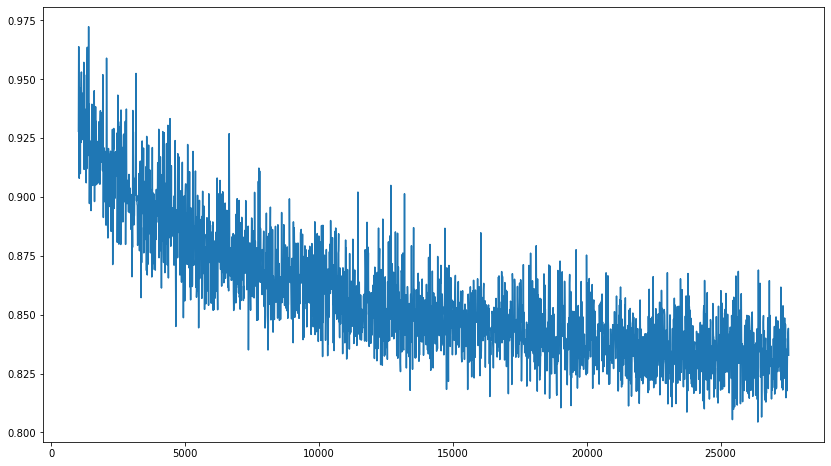

In [18]:
show_plot(counter[100:],loss_history[100:])

## Testing 

Lets run our code on the test dataset. The test dataset comprises of 

1. Gallery images
2. Query images

For every query image we have to find the gallery images which are similar to the query images. So first we shall pass both the query as well as gallery images through the network and then comparing the hash bits find the similar images.

In [19]:
class testing_dataset(Dataset):


    def __init__(self, image_dir, transform=None):
        
        img_list = os.listdir(image_dir)
        self.data =  pd.DataFrame(img_list)
        self.image_dir = image_dir
        self.transform = transform        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.data.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.convert("RGB")

        if self.transform:
          image = self.transform(image)

        sample = {'image':image, 'name':self.data.iloc[idx,0]}

        return sample

In [20]:
base_network.load_state_dict(torch.load(Config.model))

<All keys matched successfully>

In [21]:
#this function passes all the images through the network and returns the hashbits

def encoding_extractor(dataloader, net, verbosity):
  net.eval()
  with torch.no_grad(): 
    for i_batch, sample in enumerate(dataloader):
      sample['image'] = sample['image'].cuda()
      encoding = net(sample['image'])
      if not i_batch: 
        encodings = encoding
        names = sample['name']
        continue
      encodings = torch.cat([encodings, encoding], dim=0)
      #names = pd.concat([names, sample['name']], axis=0)
      names.extend(sample['name'])
      if verbosity: 
        for img in sample['name']:
          print("{} succesfully extracted".format(img))
  return encodings, names

Here we define two types of distances namely : Euclidean distance and Hamming distance. 

* Euclidean distance: gives slightly better results but takes more time
* Hamming distance: gives slightly poorer results but takes less time

In [28]:
def Euclidean_distance(verbosity):
    result=[]
    gallery = gallery_params['encodings']

    for query in query_params['encodings']:
      i=0
      while(i<gallery.shape[0]):
        matrix = torch.sum((gallery[i:i+256]-query).square(), dim=1)
        if not i: dissimilarity_matrix = matrix
        else: dissimilarity_matrix = torch.cat([dissimilarity_matrix, matrix], dim=0)
        i = i+256
      top_10 = dissimilarity_matrix.argsort(dim=0)[:10].cpu()
      if verbosity: print(top_10)
      result.append(top_10)
    return result

def Hamming_distance(verbosity):
    result=[]
    gallery = gallery_params['encodings']

    for query in query_params['encodings']:
      i=0
      while(i<gallery.shape[0]):
        matrix = torch.matmul(gallery[i:i+1024], query.view(-1,1)) * (-1.0)
        if not i: similarity_matrix = matrix
        else: similarity_matrix = torch.cat([similarity_matrix, matrix], dim=0)
        i = i+1024
      top_10 = similarity_matrix.argsort(dim=0)[:10].view(-1,).cpu()
      if verbosity: print(top_10)
      result.append(top_10)
    return result

In [23]:
gallery_encoder = testing_dataset(Config.gallery_dir,
                                    transform=Config.transformer)

gallery_dataloader = DataLoader(gallery_encoder,
                        shuffle=False,
                        num_workers=8, 
                        batch_size=Config.feature_batch_size)

In [24]:
query_encoder = testing_dataset(Config.query_dir,
                              transform=Config.transformer)

query_dataloader = DataLoader(query_encoder,
                        shuffle=False,
                        num_workers=8, 
                        batch_size=Config.feature_batch_size)

In [25]:
query_feats, query_images = encoding_extractor(query_dataloader, base_network, verbosity=0)
query_params = {'encodings':query_feats, 'names':query_images}

In [26]:
gallery_feats, gallery_images = encoding_extractor(gallery_dataloader,base_network,  verbosity=0)
gallery_params = {'encodings':gallery_feats, 'names':gallery_images}

In [29]:
result = Euclidean_distance(verbosity=0)

## Output

In [30]:
output = pd.DataFrame()

gallery_names = pd.Series(gallery_params['names'])

for img_num in range(len(result)):
    indexes = result[img_num].tolist()
    retrieved = gallery_names[indexes].to_list()
    output[query_params['names'][img_num]] = retrieved

In [31]:
output = output.transpose()
output.reset_index(inplace=True)

In [32]:
output.to_csv('./submission.csv',header=None,index=None)

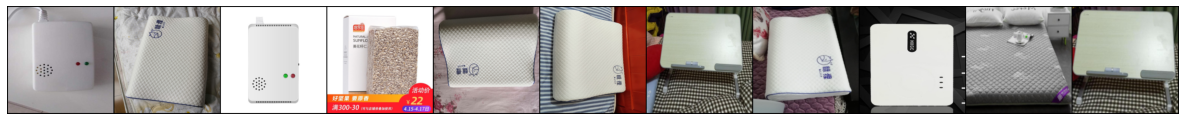

In [37]:
result = pd.read_csv('./submission.csv',header=None)

num = 121       # choose any integer between [0,41573]

query_img = Image.open(Config.query_dir+result.iloc[num,0])
query_img = Config.transformer(query_img).unsqueeze(0)

img_list = query_img
for img in result.iloc[num,1:]:
    image = Image.open(Config.gallery_dir+img)
    image = Config.transformer(image).unsqueeze(0)
    img_list = torch.cat([img_list,image])

imshow(torchvision.utils.make_grid(img_list, nrow=img_list.shape[0]))